In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DATA606 Capstone/Raw Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DATA606 Capstone/Raw Data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics 
from imblearn.over_sampling import SMOTE
import graphviz
from sklearn.tree import export_graphviz
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (10,8)

In [3]:
df = pd.read_csv('crash_weather_2015-2019.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129145 entries, 0 to 129144
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  129145 non-null  int64  
 1   X                           129145 non-null  float64
 2   Y                           129145 non-null  float64
 3   OBJECTID                    129145 non-null  int64  
 4   CRIMEID                     129145 non-null  int64  
 5   CCN                         129145 non-null  object 
 6   REPORTDATE                  129145 non-null  object 
 7   ROUTEID                     129145 non-null  object 
 8   MEASURE                     129145 non-null  float64
 9   OFFSET                      129145 non-null  float64
 10  STREETSEGID                 113667 non-null  float64
 11  ROADWAYSEGID                113667 non-null  float64
 12  FROMDATE                    129145 non-null  object 
 13  TODATE        

In [4]:
df = df[df['TOTAL_VEHICLES'] > 0]

In [5]:
df['REPORTDATE'] = pd.to_datetime(df['REPORTDATE'], errors='coerce')
df = df.loc[(df['REPORTDATE'].dt.year > 2015) & (df['REPORTDATE'].dt.year < 2020)]

# Extract year, month, day, hour and weekday
df['YEAR']=df['REPORTDATE'].dt.year
df['MONTH']=df['REPORTDATE'].dt.strftime('%b')
df['HOUR']=df['REPORTDATE'].dt.hour
df['WEEKDAY']=df['REPORTDATE'].dt.strftime('%a')

In [6]:
targets = ['MINORINJURIES_DRIVER','MAJORINJURIES_DRIVER', 'FATAL_DRIVER'] 
features = ['Temperature','Visibility','Cloud Cover', 'Wind Speed',
            'Precipitation', 'Conditions', 'MONTH', 'HOUR', 'WEEKDAY']

In [7]:
df1 = df[(df['MINORINJURIES_DRIVER'] > 0) | (df['MAJORINJURIES_DRIVER'] > 0) | (df['FATAL_DRIVER'] > 0)] 
label_df = df1[['MINORINJURIES_DRIVER','MAJORINJURIES_DRIVER','FATAL_DRIVER']]
label_df.head()

MINORINJURIES_DRIVER  MAJORINJURIES_DRIVER  FATAL_DRIVER
22411                     1                     0             0
22414                     1                     0             0
22430                     1                     0             0
22440                     1                     0             0
22442                     1                     0             0

In [8]:
print(label_df['MINORINJURIES_DRIVER'].value_counts())
print(label_df['MAJORINJURIES_DRIVER'].value_counts())
print(label_df['FATAL_DRIVER'].value_counts())

1     14270
2      1939
0       780
3       140
4        15
5         6
11        1
6         1
Name: MINORINJURIES_DRIVER, dtype: int64
0    16284
1      849
2       17
3        2
Name: MAJORINJURIES_DRIVER, dtype: int64
0    17088
1       63
2        1
Name: FATAL_DRIVER, dtype: int64


In [9]:
label_df.loc[label_df['MINORINJURIES_DRIVER'] > 0, ['Severity']] = 'Minor'
label_df.loc[label_df['MAJORINJURIES_DRIVER'] > 0, ['Severity']] = 'Major'
label_df.loc[label_df['FATAL_DRIVER'] > 0, ['Severity']] = 'Fatal'

In [10]:
print(label_df['Severity'].value_counts())

Minor    16224
Major      864
Fatal       64
Name: Severity, dtype: int64


In [11]:
df_features=df1[features].copy()
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17152 entries, 22411 to 129143
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    17152 non-null  float64
 1   Visibility     17152 non-null  float64
 2   Cloud Cover    17152 non-null  float64
 3   Wind Speed     17152 non-null  float64
 4   Precipitation  17152 non-null  float64
 5   Conditions     17152 non-null  object 
 6   MONTH          17152 non-null  object 
 7   HOUR           17152 non-null  int64  
 8   WEEKDAY        17152 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


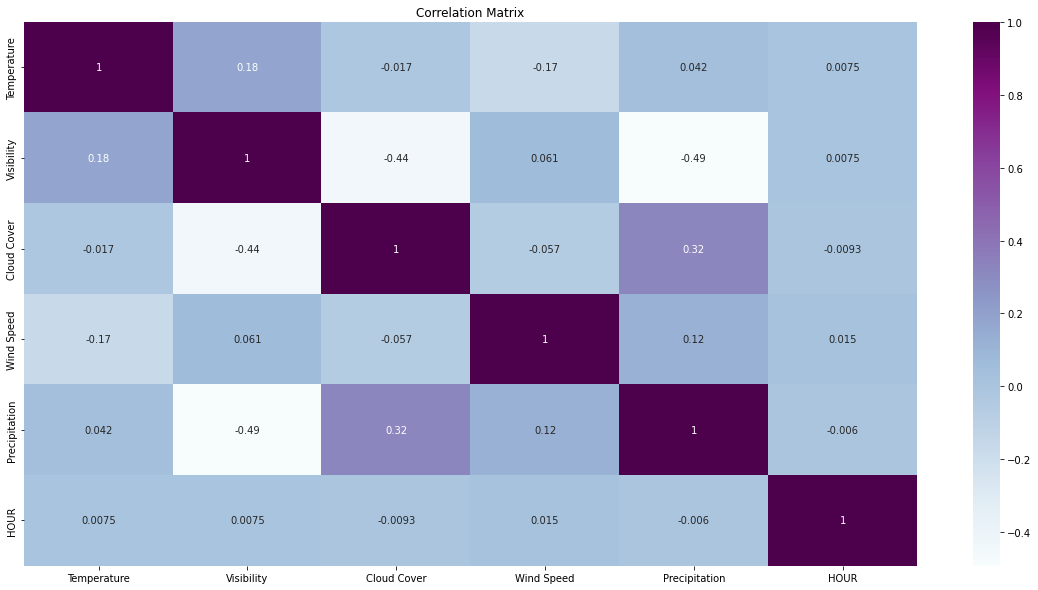

In [12]:
heat_corr = df_features.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(heat_corr, annot=True, cmap='BuPu')
plt.title("Correlation Matrix")
plt.show()

In [13]:
df_features.shape

(17152, 9)

In [14]:
df_features.isnull().sum()

Temperature      0
Visibility       0
Cloud Cover      0
Wind Speed       0
Precipitation    0
Conditions       0
MONTH            0
HOUR             0
WEEKDAY          0
dtype: int64

In [15]:
df_features = pd.get_dummies(df_features)
df_features.columns

Index(['Temperature', 'Visibility', 'Cloud Cover', 'Wind Speed',
       'Precipitation', 'HOUR', 'Conditions_Clear', 'Conditions_Overcast',
       'Conditions_Partially cloudy', 'Conditions_Rain',
       'Conditions_Rain, Overcast', 'Conditions_Rain, Partially cloudy',
       'Conditions_Snow', 'Conditions_Snow, Overcast',
       'Conditions_Snow, Partially cloudy', 'MONTH_Apr', 'MONTH_Aug',
       'MONTH_Dec', 'MONTH_Feb', 'MONTH_Jan', 'MONTH_Jul', 'MONTH_Jun',
       'MONTH_Mar', 'MONTH_May', 'MONTH_Nov', 'MONTH_Oct', 'MONTH_Sep',
       'WEEKDAY_Fri', 'WEEKDAY_Mon', 'WEEKDAY_Sat', 'WEEKDAY_Sun',
       'WEEKDAY_Thu', 'WEEKDAY_Tue', 'WEEKDAY_Wed'],
      dtype='object')

In [16]:
hour_dummy = pd.get_dummies(df_features['HOUR'])
hour_dummy.columns = ['Hour_0','Hour_1','Hour_2','Hour_3','Hour_4','Hour_5','Hour_6','Hour_7','Hour_8','Hour_9',
                 'Hour_10','Hour_11','Hour_12','Hour_13','Hour_14','Hour_15','Hour_16','Hour_17','Hour_18',
                 'Hour_19','Hour_20','Hour_21','Hour_22','Hour_23']
df_features = pd.concat([df_features, hour_dummy] , axis = 1)

In [17]:
df_features.drop(columns='HOUR', inplace=True)
df_features.columns

Index(['Temperature', 'Visibility', 'Cloud Cover', 'Wind Speed',
       'Precipitation', 'Conditions_Clear', 'Conditions_Overcast',
       'Conditions_Partially cloudy', 'Conditions_Rain',
       'Conditions_Rain, Overcast', 'Conditions_Rain, Partially cloudy',
       'Conditions_Snow', 'Conditions_Snow, Overcast',
       'Conditions_Snow, Partially cloudy', 'MONTH_Apr', 'MONTH_Aug',
       'MONTH_Dec', 'MONTH_Feb', 'MONTH_Jan', 'MONTH_Jul', 'MONTH_Jun',
       'MONTH_Mar', 'MONTH_May', 'MONTH_Nov', 'MONTH_Oct', 'MONTH_Sep',
       'WEEKDAY_Fri', 'WEEKDAY_Mon', 'WEEKDAY_Sat', 'WEEKDAY_Sun',
       'WEEKDAY_Thu', 'WEEKDAY_Tue', 'WEEKDAY_Wed', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')

In [18]:
print(df_features.shape)
print(label_df.shape)

(17152, 57)
(17152, 4)


## Injury Severity Classification

In [19]:
y = label_df['Severity']
X = df_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest (Unbalanaced)

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [21]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00        25
       Major       0.10      0.03      0.05       251
       Minor       0.95      0.99      0.97      4870

    accuracy                           0.93      5146
   macro avg       0.35      0.34      0.34      5146
weighted avg       0.90      0.93      0.92      5146



In [22]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix

array([[   0,    0,   25],
       [   0,    8,  243],
       [   1,   72, 4797]])

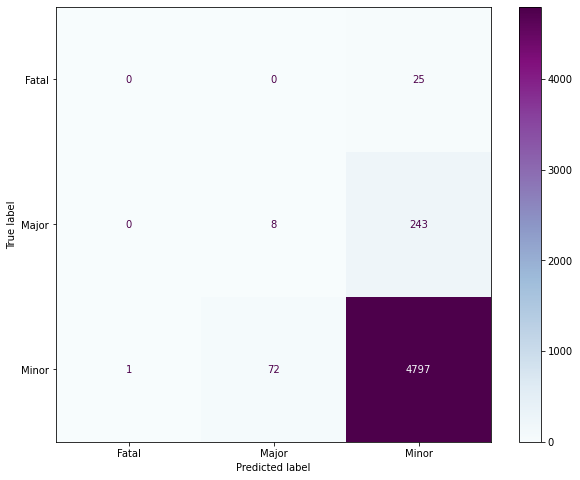

In [23]:
label = ['Fatal', 'Major', 'Minor']
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf, labels=label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

### XGBoost (Unbalanced)

In [24]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [25]:
print(metrics.classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00        25
       Major       0.00      0.00      0.00       251
       Minor       0.95      1.00      0.97      4870

    accuracy                           0.95      5146
   macro avg       0.32      0.33      0.32      5146
weighted avg       0.90      0.95      0.92      5146



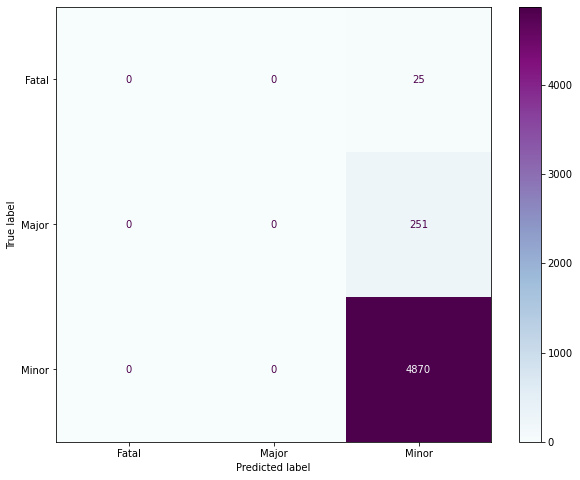

In [26]:
cm_xgb = metrics.confusion_matrix(y_test, y_pred_xgb, labels=label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

## SMOTE - Balance the data

In [27]:
print('After OverSampling, the shape of train_X: {}'.format(X.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y.shape))

print("Before OverSampling, counts of label '0': {}".format(sum(y == 0)))
print("Before OverSampling, counts of label '1': {} \n".format(sum(y == 1)))
print("Before OverSampling, counts of label '2': {} \n".format(sum(y == 2)))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))
print("After OverSampling, counts of label '1': {} \n".format(sum(y_res == 1)))
print("After OverSampling, counts of label '2': {} \n".format(sum(y_res == 2)))

After OverSampling, the shape of train_X: (17152, 57)
After OverSampling, the shape of train_y: (17152,) 

Before OverSampling, counts of label '0': 0
Before OverSampling, counts of label '1': 0 

Before OverSampling, counts of label '2': 0 

After OverSampling, the shape of train_X: (34062, 57)
After OverSampling, the shape of train_y: (34062,) 

After OverSampling, counts of label '0': 0
After OverSampling, counts of label '1': 0 

After OverSampling, counts of label '2': 0 



#### Re-split the train/test data

In [28]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

### Random Forest (Balanced)

In [29]:
rf1 = RandomForestClassifier(n_estimators=100, random_state=42)

rf1.fit(X_train_res, y_train_res)

y_pred_res1 = rf.predict(X_test_res)

In [30]:
print(metrics.classification_report(y_test_res, y_pred_res1))

              precision    recall  f1-score   support

       Fatal       1.00      0.00      0.00      3415
       Major       0.98      0.04      0.08      3401
       Minor       0.34      1.00      0.50      3403

    accuracy                           0.35     10219
   macro avg       0.77      0.35      0.20     10219
weighted avg       0.77      0.35      0.20     10219



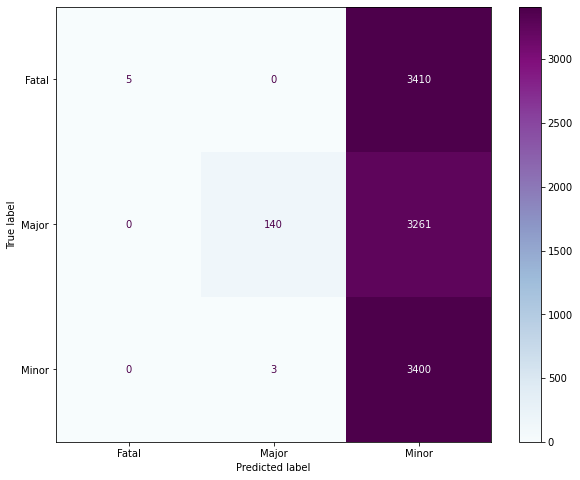

In [31]:
cm_rf1 = metrics.confusion_matrix(y_test_res, y_pred_res1, labels=label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf1, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

### XGBoost (Balanced)

In [32]:
xgb1 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb1.fit(X_train_res, y_train_res)
y_pred_xgb1 = xgb1.predict(X_test_res)

In [33]:
print(metrics.classification_report(y_test_res, y_pred_xgb1))

              precision    recall  f1-score   support

       Fatal       0.75      0.86      0.80      3415
       Major       0.80      0.55      0.66      3401
       Minor       0.85      0.99      0.91      3403

    accuracy                           0.80     10219
   macro avg       0.80      0.80      0.79     10219
weighted avg       0.80      0.80      0.79     10219



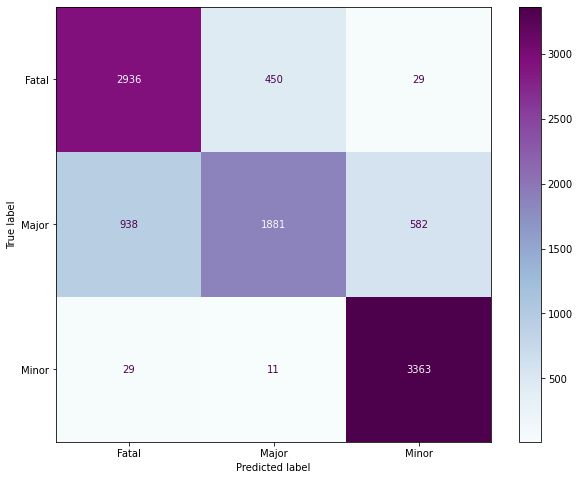

In [34]:
cm_xgb1 = metrics.confusion_matrix(y_test_res, y_pred_xgb1, labels=label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb1, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

### Random Forest CV Grid Search

In [35]:
param_rf = { 
    'n_estimators': [100,200,400,600,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth'   : [4,6,8],
    'criterion'   :['gini', 'entropy']
}

In [36]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_rf, cv= 5)
CV_rfc.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 400, 600, 800]})

In [37]:
print(CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}


In [38]:
rf2 = RandomForestClassifier(n_estimators=800, 
                              criterion='entropy', 
                              max_features='auto',
                              max_depth=8,
                              random_state=42)

rf2.fit(X_train_res, y_train_res)

y_pred_res2 = rf2.predict(X_test_res)

In [39]:
print(metrics.classification_report(y_test_res, y_pred_res2))

              precision    recall  f1-score   support

       Fatal       0.71      0.86      0.78      3415
       Major       0.77      0.46      0.57      3401
       Minor       0.82      0.98      0.89      3403

    accuracy                           0.77     10219
   macro avg       0.77      0.77      0.75     10219
weighted avg       0.77      0.77      0.75     10219



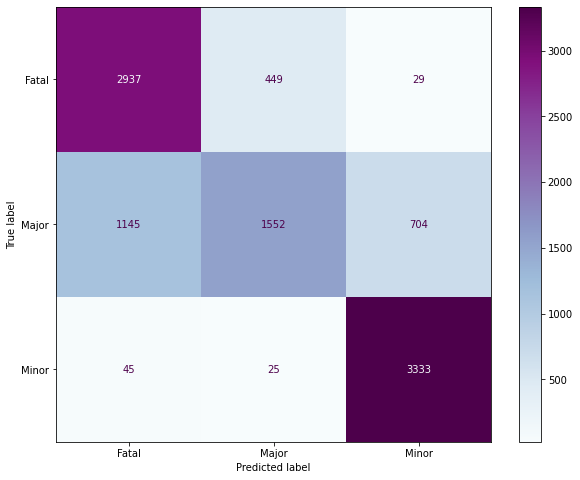

In [40]:
cm_rf2 = metrics.confusion_matrix(y_test_res, y_pred_res2, labels=label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf2, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

### XGBoost CV Grid Search

In [41]:
param_grid_xgb = {'n_estimators': [100, 200, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.20],
    }

In [43]:
CV_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42), param_grid=param_grid_xgb, cv= 5)
CV_xgb.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=XGBClassifier(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 400]})

In [44]:
print(CV_xgb.best_params_)

{'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 400}


In [45]:
xgb2 = XGBClassifier(use_label_encoder=False, learning_rate= 0.2, 
                     max_depth= 6, n_estimators= 400, eval_metric='mlogloss', random_state=42)
xgb2.fit(X_train_res, y_train_res)
y_pred_xgb2 = xgb2.predict(X_test_res)

In [46]:
print(metrics.classification_report(y_test_res, y_pred_xgb2))

              precision    recall  f1-score   support

       Fatal       0.99      0.99      0.99      3415
       Major       0.98      0.94      0.95      3401
       Minor       0.95      0.98      0.96      3403

    accuracy                           0.97     10219
   macro avg       0.97      0.97      0.97     10219
weighted avg       0.97      0.97      0.97     10219



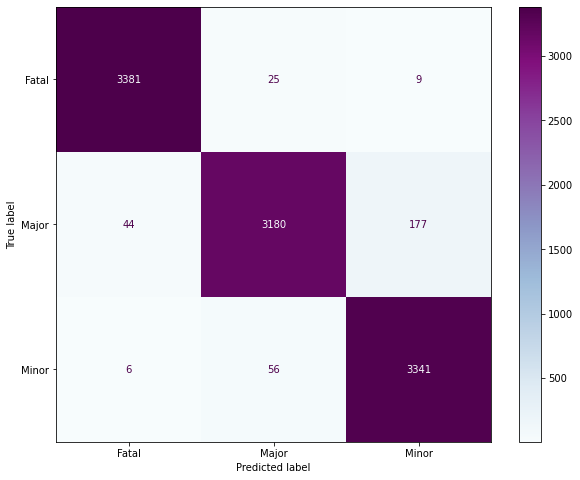

In [47]:
cm_xgb2 = metrics.confusion_matrix(y_test_res, y_pred_xgb2, labels=label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb2, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

## Feature Importance

#### Random Forest

In [48]:
importances_rf = rf2.feature_importances_

In [49]:
imp = pd.DataFrame(importances_rf)
imp['Features'] = df_features.columns
imp.rename(columns={0:'Importance'}, inplace=True)
imp = imp.sort_values(by='Importance', ascending=False)
imp = imp[['Features', 'Importance']]
imp

Features  Importance
26                        WEEKDAY_Fri    0.082912
2                         Cloud Cover    0.077074
30                        WEEKDAY_Thu    0.068196
0                         Temperature    0.065272
7         Conditions_Partially cloudy    0.059689
32                        WEEKDAY_Wed    0.057456
31                        WEEKDAY_Tue    0.049726
3                          Wind Speed    0.044127
28                        WEEKDAY_Sat    0.042786
1                          Visibility    0.037623
27                        WEEKDAY_Mon    0.036514
22                          MONTH_May    0.035566
4                       Precipitation    0.032784
15                          MONTH_Aug    0.031183
25                          MONTH_Sep    0.030980
23                          MONTH_Nov    0.029072
29                        WEEKDAY_Sun    0.028631
10  Conditions_Rain, Partially cloudy    0.020267
9           Conditions_Rain, Overcast    0.018543
48                            Hour_15    0.011062
16                          MONTH_Dec    0.010947
14                          MONTH_Apr    0.009669
47                            Hour_14    0.009315
18                          MONTH_Jan    0.009177
33                             Hour_0    0.009029
20                          MONTH_Jun    0.007601
21                          MONTH_Mar    0.007325
6                 Conditions_Overcast    0.006699
5                    Conditions_Clear    0.006468
54                            Hour_21    0.005707
24                          MONTH_Oct    0.005572
19                          MONTH_Jul    0.005134
17                          MONTH_Feb    0.005116
49                            Hour_16    0.005050
56                            Hour_23    0.004718
35                             Hour_2    0.004411
50                            Hour_17    0.004138
34                             Hour_1    0.004127
37                             Hour_4    0.003583
55                            Hour_22    0.003399
51                            Hour_18    0.003144
52                            Hour_19    0.002285
36                             Hour_3    0.002201
12          Conditions_Snow, Overcast    0.000979
46                            Hour_13    0.000977
53                            Hour_20    0.000807
38                             Hour_5    0.000560
39                             Hour_6    0.000349
42                             Hour_9    0.000310
13  Conditions_Snow, Partially cloudy    0.000292
43                            Hour_10    0.000275
40                             Hour_7    0.000266
41                             Hour_8    0.000242
44                            Hour_11    0.000242
11                    Conditions_Snow    0.000214
45                            Hour_12    0.000157
8                     Conditions_Rain    0.000055

In [50]:
fig = px.bar(imp, x='Importance', y='Features', title='Feature Importance', color ='Features', orientation='h')
fig.show()

#### XGBoost 

In [51]:
importances_xgb = xgb2.feature_importances_

In [52]:
imp2 = pd.DataFrame(importances_xgb)
imp2['Features'] = df_features.columns
imp2.rename(columns={0:'Importance'}, inplace=True)
imp2 = imp2.sort_values(by='Importance', ascending=False)
imp2 = imp2[['Features', 'Importance']]
imp2

Features  Importance
32                        WEEKDAY_Wed    0.061686
31                        WEEKDAY_Tue    0.059826
27                        WEEKDAY_Mon    0.049440
28                        WEEKDAY_Sat    0.048315
26                        WEEKDAY_Fri    0.048211
30                        WEEKDAY_Thu    0.041816
5                    Conditions_Clear    0.040978
29                        WEEKDAY_Sun    0.039238
15                          MONTH_Aug    0.028770
25                          MONTH_Sep    0.025870
47                            Hour_14    0.023799
7         Conditions_Partially cloudy    0.023181
22                          MONTH_May    0.020297
20                          MONTH_Jun    0.019879
48                            Hour_15    0.019606
34                             Hour_1    0.017777
46                            Hour_13    0.017290
49                            Hour_16    0.016698
33                             Hour_0    0.015657
9           Conditions_Rain, Overcast    0.015517
54                            Hour_21    0.015325
55                            Hour_22    0.015318
10  Conditions_Rain, Partially cloudy    0.014707
53                            Hour_20    0.014686
52                            Hour_19    0.014445
6                 Conditions_Overcast    0.014273
56                            Hour_23    0.013684
37                             Hour_4    0.013610
39                             Hour_6    0.013299
36                             Hour_3    0.013182
45                            Hour_12    0.012983
19                          MONTH_Jul    0.012739
50                            Hour_17    0.012352
23                          MONTH_Nov    0.012232
14                          MONTH_Apr    0.012204
51                            Hour_18    0.010564
43                            Hour_10    0.010377
42                             Hour_9    0.010162
38                             Hour_5    0.009943
24                          MONTH_Oct    0.009830
41                             Hour_8    0.009786
44                            Hour_11    0.009625
40                             Hour_7    0.009554
18                          MONTH_Jan    0.009485
1                          Visibility    0.009168
35                             Hour_2    0.008940
2                         Cloud Cover    0.007436
0                         Temperature    0.007178
11                    Conditions_Snow    0.007005
4                       Precipitation    0.006579
3                          Wind Speed    0.006298
21                          MONTH_Mar    0.005940
16                          MONTH_Dec    0.005590
17                          MONTH_Feb    0.005089
13  Conditions_Snow, Partially cloudy    0.001517
12          Conditions_Snow, Overcast    0.001046
8                     Conditions_Rain    0.000000

In [53]:
fig = px.bar(imp2, x='Importance', y='Features', title='Feature Importance', color ='Features', orientation='h')
fig.show()

### Display Random Forest tree

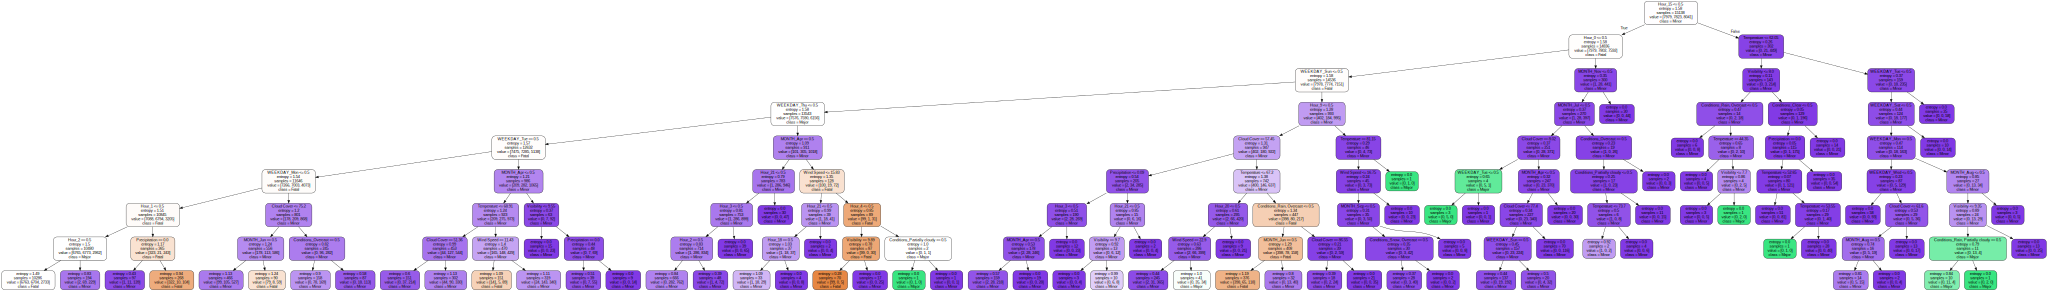

In [54]:
# Export as dot file
tree = export_graphviz(rf2.estimators_[0], 
                out_file= None,
                feature_names = X_train.columns,
                class_names = label,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
graphviz.Source(tree)